In [1]:
from ripser import ripser
from persim import plot_diagrams
import numpy as np
from numpy import pi,cos,sin
import matplotlib.pyplot as plt
import random


import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [2]:
def get_pixels(num_pixels, window_size):
    sample = list(np.linspace(-window_size/2, window_size/2, num_pixels))
    pixels = []
    for i in range(len(sample)):
        for j in range(len(sample)):
            pixels.append((sample[i],sample[j]))     
    return pixels


def get_colors(pixels, image_function):
    colors = []
    for pixel in pixels:
        colors.append(image_function(pixel[0],pixel[1]))
    return colors  

def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab

def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta

def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso

def generate_isom(n_isos, x_translate, y_translate):
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) # sampling from (-y,y)
    theta = list(2 * pi * np.random.random(n_isos)) # sampling from (0, 2pi)

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv

def new_colors(pixels, iso_inv, image_function):
    pixels_inv = []
    for pixel in pixels: 
        pixels_inv.append(iso_inv(pixel[0], pixel[1]))
    new_colors = get_colors(pixels_inv, image_function)
    return new_colors

def matrix_of_images(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([new_colors(pixels, i, image_function)])
    M = np.concatenate(vectors, axis=0 )
    return M

def p_hom(M, maxdim, coeff):
    output = ripser(M, maxdim = maxdim, coeff = coeff)
    return output
    
def persistent_H1_intervals(output):
    H1 = output['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    d
    return d

def plot_dgms(output):
    dgms = output['dgms']
    fig = plt.figure(figsize = (12, 6))
    plot_diagrams(dgms)
    
def pipeline(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

def graph(image_function, x, y, x_random = True, n_samples= 100000, y_random = True):
    
    if x_random == True:
        X = list(2 * x * np.random.random(n_samples) - x) 
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)      

    if x_random == False:
        X = np.linspace(-x,x,n_samples)
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)   

    points = []
    for i in range(n_samples):
        color = image_function(X[i],Y[i])
        if color == 1:
            points.append((X[i],Y[i])) 
        
    x_points = []
    y_points = []
    for i in points: 
        x_points.append(i[0])
        y_points.append(i[1])
        
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points)
    plt.show()
    
def view_window(image_function, num_pixels, window_size):
    
    pixels = get_pixels(num_pixels, window_size)

    points = []
    for pixel in pixels:
        color = image_function(pixel[0],pixel[1])
        if color == 1:
            points.append(pixel)
    
    x_points = []
    y_points = []
    for pixel in points:
        x_points.append(pixel[0])
        y_points.append(pixel[1])
    
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points)
    plt.show()

In [3]:
def sine(x,y):
    ret = 0
    for a in range(-10,10):
        if sin(x) - 0.1 + 2*a <= y <= sin(x) + 0.1 + 2*a:
            ret = 1
    return ret

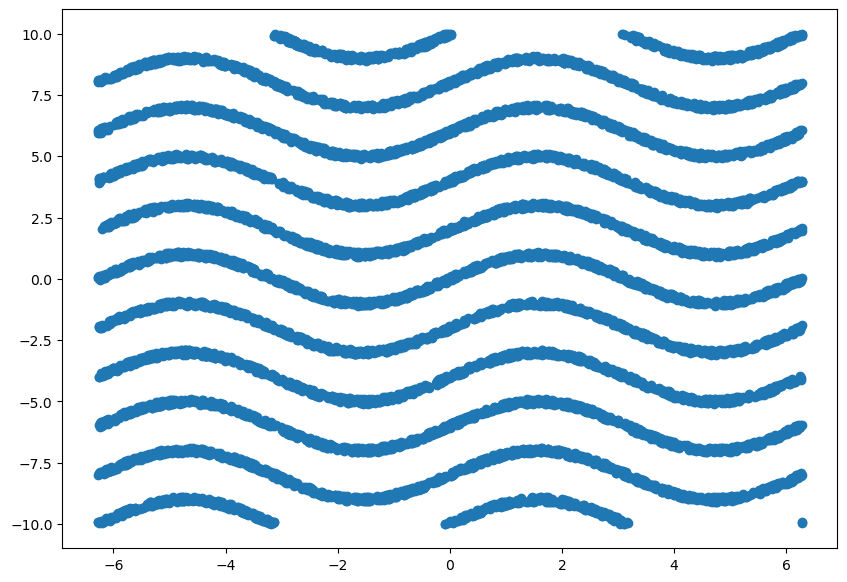

In [4]:
graph(sine, 2 * pi, 10, x_random = True, n_samples= 100000, y_random = True)

In [5]:
output = pipeline(image_function = sine, num_pixels = 80, window_size = 4, n_isos= 3000, x_translate = 5, y_translate = 5, maxdim=1, coeff=2)
plot_dgms(output)

KeyboardInterrupt: 

**This is not what I was hoping for...**

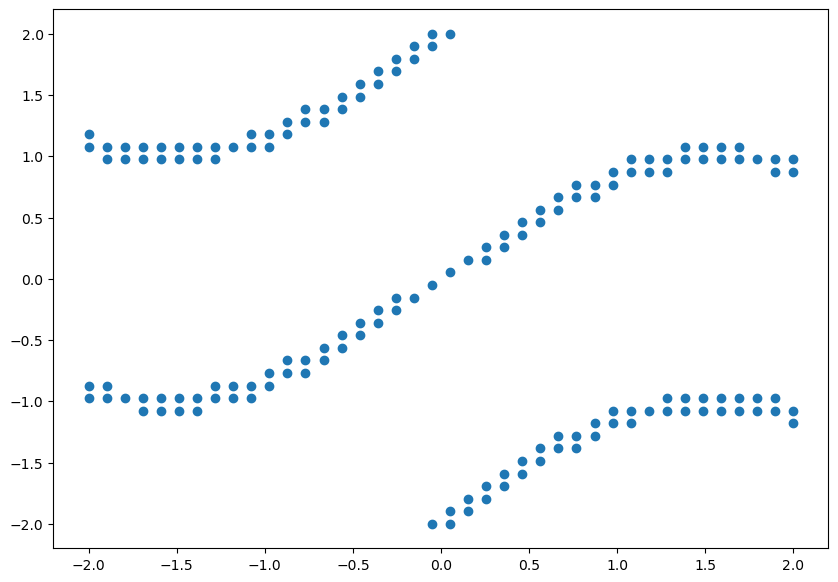

In [6]:
view_window(sine, 40, 4)

In [46]:
def rhombus(x,y): 
    ret = 0 
    for a in range(5):
        if (3 ** 0.5 * x - 0.1) + 2 * a * (3 ** 0.5) <= y <= (3 ** 0.5 * x + 0.1) + 2 * a * (3 ** 0.5):
            ret = 1
        if (3 ** 0.5 * x - 0.1) + 2 * (-a) * (3 ** 0.5) <= y <= (3 ** 0.5 * x + 0.1) + 2 * (-a) * (3 ** 0.5):
            ret = 1
        if (-3 ** 0.5 * x - 0.1)+ 2 * a * (3 ** 0.5) <= y <= (-3 ** 0.5 * x + 0.1) + 2 * a * (3 ** 0.5):
            ret = 1
        if (-3 ** 0.5 * x - 0.1)+ 2 * (-a) * (3 ** 0.5) <= y <= (-3 ** 0.5 * x + 0.1) + 2 * (-a) * (3 ** 0.5):
            ret = 1
    return ret

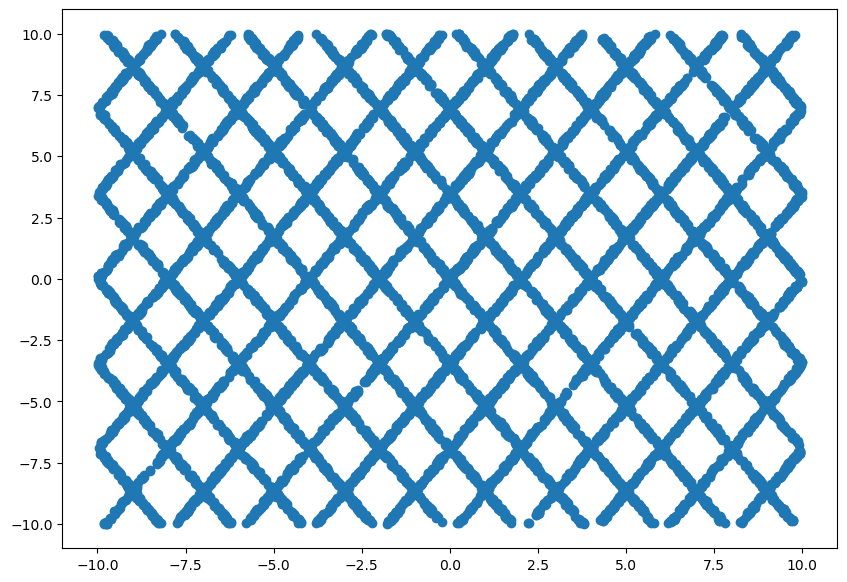

In [9]:
graph(rhombus, 10, 10, x_random = True, n_samples= 100000, y_random = True)

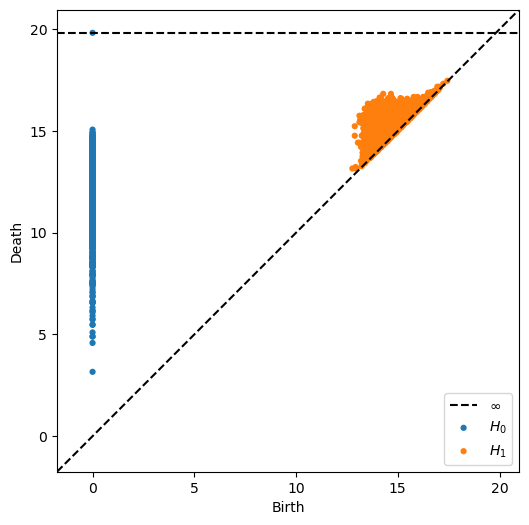

In [15]:
output = pipeline(image_function=rhombus, num_pixels=40, window_size=4, n_isos=3000, x_translate=5, y_translate=5, maxdim=1, coeff=2)
plot_dgms(output)

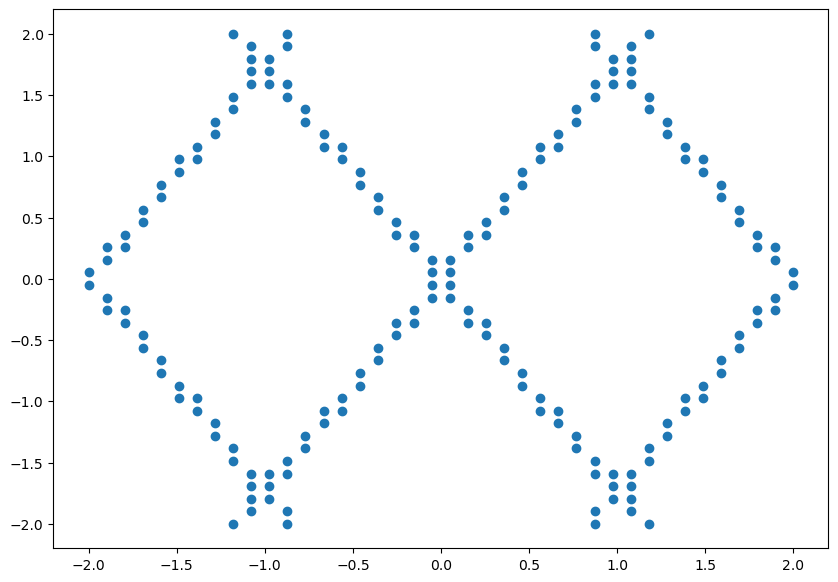

In [14]:
view_window(rhombus, 40, 4)

In [11]:
def generate_isom2(n_isos, x_translate, y_translate):
    a = list(np.linspace(-x_translate/2, x_translate/2, n_isos)) # sampling from (-x,x)
    b = list(np.linspace(-y_translate/2, y_translate/2, n_isos)) # sampling from (-y,y)
    theta = (n_isos // 31 * (np.linspace(0, 2*pi, 31)).tolist())
    theta2 = (np.linspace(0, 2*pi, n_isos % 31)).tolist()
    for i in theta2:
        theta.append(i)

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv




In [12]:
def pipeline2(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom2(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

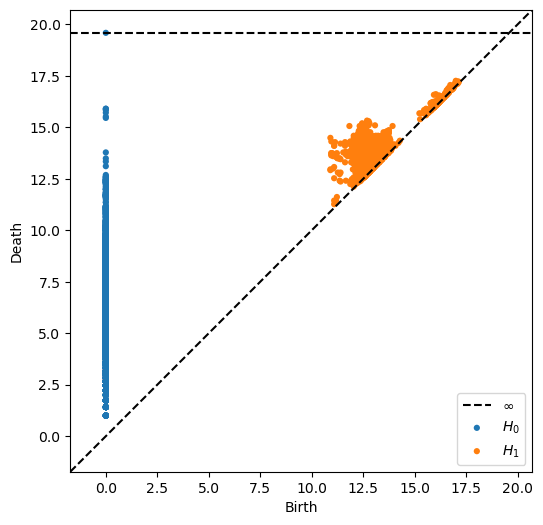

In [14]:
output = pipeline2(image_function=rhombus, num_pixels=40, window_size=4, n_isos=5000, x_translate=5, y_translate=5, maxdim=1, coeff=2)
plot_dgms(output)

In [4]:
def generate_isom3(n_theta, n_translates, x_translate, y_translate):
    a = list(np.linspace(-x_translate/2, x_translate/2, n_translates)) # sampling from (-x,x)
    b = list(np.linspace(-y_translate/2, y_translate/2, n_translates)) # sampling from (-y,y)
    theta = ((np.linspace(0, 2*pi, n_theta)).tolist())

    isos = []
    isos_inv = []
    for i in range(n_theta):
        update_progress(i / n_theta)
        for j in range(n_translates):
            for k in range(n_translates):
                isos.append(isom(a[j], b[k], theta[i]))
                isos_inv.append(isom(-1 * a[j],-1 * b[k],2 * pi - theta[i])) 
    return isos_inv

In [5]:
def pipeline3(image_function, num_pixels, window_size, n_theta, n_translates, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom3(n_theta, n_translates, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

In [17]:
def matrix_of_images(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([new_colors(pixels, i, image_function)])
    M = np.concatenate(vectors, axis=0 )
    return M

Progress: [####################] 98.0%


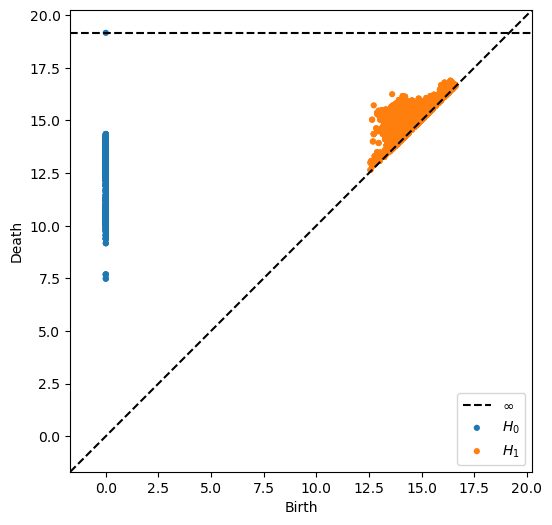

In [18]:
output = pipeline3(image_function=rhombus, num_pixels=40, window_size=4, n_theta=50, n_translates = 10, x_translate=5, y_translate=5, maxdim=1, coeff=2)
plot_dgms(output)

In [41]:
def generate_isom4(n_theta, n_translates, x_translate, y_translate):
    a = list(np.linspace(-x_translate/2, x_translate/2, n_translates)) # sampling from (-x,x)
    b = list(np.linspace(-y_translate/2, y_translate/2, n_translates)) # sampling from (-y,y)
    theta = ((np.linspace(0, 2*pi, n_theta - (6 * (n_theta//18))).tolist()))
    theta2 = n_theta // 18 * [0, pi / 3, 2 * pi / 3, pi, 4 * pi / 3, 5 * pi / 3]
    
    for i in range(len(theta2)):
        theta.append(theta2[i])

    isos = []
    isos_inv = []
    for i in range(n_theta):
        for j in range(n_translates):
            for k in range(n_translates):
                isos.append(isom(a[j], b[k], theta[i]))
                isos_inv.append(isom(-1 * a[j],-1 * b[k],2 * pi - theta[i])) 
    return isos_inv

In [42]:
def pipeline4(image_function, num_pixels, window_size, n_theta, n_translates, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom4(n_theta, n_translates, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

In [ ]:
output = pipeline4(image_function=rhombus, num_pixels=20, window_size=2, n_theta=70, n_translates = 10, x_translate=2.5, y_translate=2.5, maxdim=1, coeff=2)
plot_dgms(output)

In [45]:
theta = ((np.linspace(0, 2*pi, 100 - (6 * (100//18))).tolist()))
theta2 = 100 // 18 * [0, pi / 3, 2 * pi / 3, pi, 4 * pi / 3, 5 * pi / 3]
    
for i in range(len(theta2)):
    theta.append(theta2[i])
    
theta

[0.0,
 0.0910606566257911,
 0.1821213132515822,
 0.2731819698773733,
 0.3642426265031644,
 0.4553032831289555,
 0.5463639397547466,
 0.6374245963805377,
 0.7284852530063288,
 0.8195459096321199,
 0.910606566257911,
 1.001667222883702,
 1.0927278795094932,
 1.1837885361352845,
 1.2748491927610754,
 1.3659098493868664,
 1.4569705060126577,
 1.5480311626384489,
 1.6390918192642399,
 1.7301524758900308,
 1.821213132515822,
 1.9122737891416133,
 2.003334445767404,
 2.0943951023931953,
 2.1854557590189865,
 2.2765164156447777,
 2.367577072270569,
 2.4586377288963597,
 2.549698385522151,
 2.640759042147942,
 2.731819698773733,
 2.822880355399524,
 2.9139410120253153,
 3.0050016686511065,
 3.0960623252768977,
 3.1871229819026885,
 3.2781836385284797,
 3.369244295154271,
 3.4603049517800617,
 3.551365608405853,
 3.642426265031644,
 3.7334869216574353,
 3.8245475782832266,
 3.9156082349090173,
 4.006668891534808,
 4.0977295481606,
 4.1887902047863905,
 4.279850861412182,
 4.370911518037973,
 4.4